## Kaggle Superheroes Competition

Team: PatataCaliente

In [112]:
# Imports
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.utils import resample
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB

In [113]:
#pip install imblearn --user

In [114]:
# Read datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [115]:
eye_colors = ['brown', 'blue', 'green', 'black', 'white', 'amber', 'red',
              'grey', 'hazel', 'yellow', 'purple', 'gold', 'violet', 'silver', 'other']
races = ['yautja', 'human', 'asgardian', 'mutant', 'cosmic', 'alpha',
         'animal', 'zombie', 'alien', "yoda's species", 'kryptonian', 'bizarro'
         'vampire', 'vuldarian', 'android', 'god', 'eternal', 'atlantean',
         'radiation', 'demon','cyborg', 'inhuman', 'korugaran', 'amazon',
         'symbiote', 'talokite', 'metahuman', 'altered', 'cosmic',
         'dathomirian zabrak', 'rodian', 'gungan', 'new God', 'neyaphem', 'kree',
         'demi-god', 'flora colossus', 'ungaran', 'gorilla', 'clone',
         'zen', 'whoberian', 'luphomoid', 'icthyo sapien', 'tamaranean', 'spartoi', 'other']
hair_colors = ['brown', 'blond', 'red', 'black', 'auburn', 'no hair',
               'white', 'green', 'grey', 'orange', 'purple', 'blue',
               'magenta', 'pink', 'gold', 'silver', 'other']
skin_colors = ['gold', 'silver', 'green', 'white', 'blue', 'red', 'pink',
               'black', 'grey', 'orange', 'purple', 'yellow', 'other']

### Feature Engineering

In [116]:
def generate_dummies(df):
    for col in df.columns:
        if df[col].dtype == np.object and col != 'Alignment':
            dummies = pd.get_dummies(df[col], prefix=col)
            df = df.join(dummies)
            df = df.drop(col, axis=1)
            
    return df

def clean_weight_height(train, test):
    cols = ['Race', 'Gender']
    #print(train.groupby(cols)['Weight'].mean())

    weight_median = train[train['Weight'] >= 0].groupby(cols).Weight.median()
    height_median = train[train['Height'] >= 0].groupby(cols).Height.median()
    
    train = sub(train, weight_median, 'Weight')
    train = sub(train, height_median, 'Height')
    test = sub(test, weight_median, 'Weight')
    test = sub(test, height_median, 'Height')
    
    #print(train.groupby(cols)['Weight'].mean())
    
    return train, test
    
def sub(df, median_groupby, col):
    cols = ['Race', 'Gender']
    df_w = df[df[col] < 0]
    df = df[df[col] >= 0]
    if col == 'Weight':
        df_w = df_w.assign(Weight=df_w.set_index(cols).index.map(median_groupby))
    else:
        df_w = df_w.assign(Height=df_w.set_index(cols).index.map(median_groupby))
    df_w[col] = df_w[col].fillna(-99)
    df = pd.concat([df, df_w])
    return df.sort_index()

def add_columns(df, columns):
    # Add non existing columns
    for col in columns:
        if col not in df.columns:
            df[col] = 0
    
    # Remove extra columns
    for col in df.columns:
        if col not in columns:
            df = df.drop(col, axis=1)
    return df

In [117]:
def clean_data(df):
    """
    General feature engineering function.
    
    Args:
        df -> pandas dataframe
    """
    columns = df.columns
    for col in columns:
        if df[col].dtype == np.bool:
            df[col].fillna(False, inplace=True)
            df[col] = df[col].astype(int)
        elif df[col].dtype == np.float64:
            df[col].fillna(-99, inplace=True)
        elif df[col].dtype == np.object and col != 'Alignment':
            df[col].fillna('', inplace=True)
    
    # Eye color clean
    for color in eye_colors:
        df['Eye color ' + color] = 0
        df.loc[df['Eye color'].str.contains(color), 'Eye color ' + color] = 1
    df.loc[df[['Eye color ' + color for color in eye_colors]].sum(axis=1) == 0, 'Eye color other'] = 1
    df.drop('Eye color', axis=1, inplace=True)
    
    # Race clean
    for race in races:
        df['Race ' + race] = 0
        df.loc[df['Race'].str.contains(race), 'Race ' + color] = 1
    df.loc[df[['Race ' + race for race in races]].sum(axis=1) == 0, 'Race other'] = 1
    df.drop('Race', axis=1, inplace=True)

    # Hair color clean
    for color in hair_colors:
        df['Hair color ' + color] = 0
        df.loc[df['Hair color'].str.contains(color), 'Hair color ' + color] = 1
    df.loc[df[['Hair color ' + color for color in hair_colors]].sum(axis=1) == 0, 'Hair color other'] = 1
    df.drop('Hair color', axis=1, inplace=True)
    
    # Skin color clean
    for color in skin_colors:
        df['Skin color ' + color] = 0
        df.loc[df['Skin color'].str.contains(color), 'Skin color ' + color] = 1
    df.loc[df[['Skin color ' + color for color in skin_colors]].sum(axis=1) == 0, 'Skin color other'] = 1
    df.drop('Skin color', axis=1, inplace=True)

    return df

In [118]:
# Infer weight and height
#train_clean, test_clean = clean_weight_height(train, test)

train_clean = clean_data(train)
test_clean = clean_data(test)

train_clean = generate_dummies(train_clean)
test_clean = generate_dummies(test_clean)

# Drop ID column
train_clean = train_clean.drop('Id', axis=1)
test_id = test_clean['Id']
test_clean = test_clean.drop('Id', axis=1)

In [119]:
# Remove boolean columns that are to imbalanced
"""threshold = 0.2
for col in train_clean.columns:
    if train_clean[col].dtype == np.bool:
        i, j = train_clean[col].value_counts()
        if j < (i + j) * threshold or i < (i + j) * threshold:
            train_clean.drop(col, axis=1, inplace=True)
            print('Dropped column: ', col)"""

"threshold = 0.2\nfor col in train_clean.columns:\n    if train_clean[col].dtype == np.bool:\n        i, j = train_clean[col].value_counts()\n        if j < (i + j) * threshold or i < (i + j) * threshold:\n            train_clean.drop(col, axis=1, inplace=True)\n            print('Dropped column: ', col)"

In [120]:
# Final dataframes for training
y = train_clean['Alignment']
X = train_clean.drop('Alignment', axis=1)

test_clean = add_columns(test_clean, X.columns)

# Reorder columns to have same order on train and test
train_clean = train_clean.reindex(sorted(train_clean.columns), axis=1)
test_clean = test_clean.reindex(sorted(test_clean.columns), axis=1)

# Make sure we have the same columns for train and test
assert set(train_clean.drop('Alignment', axis=1).columns) == set(test_clean.columns)

In [45]:
# Upsampling
ros = RandomOverSampler(random_state=0)
X_neutral, y_neutral = X[y == 'neutral'], y[y == 'neutral']
X_res, y_res = X[y != 'neutral'], y[y != 'neutral']

X_res, y_res = ros.fit_resample(X_res, y_res)
X = pd.concat([X_res, X_neutral]).sort_index()
y = pd.concat([y_res, y_neutral]).sort_index()
y.value_counts()

good       262
bad        262
neutral     18
Name: Alignment, dtype: int64

In [121]:
## Normalize data
scaler = preprocessing.MinMaxScaler()
X[['Weight', 'Height']] = scaler.fit_transform(X[['Weight', 'Height']])
test_clean[['Weight', 'Height']] = scaler.transform(test_clean[['Weight', 'Height']])

In [122]:
# Do the PCA decomposition!
from sklearn.decomposition import PCA

pca = PCA(tol=.95, n_components=100)
pca.fit(X)

#X = pca.transform(X) #concatenates vectors row by row
#test_clean = pca.transform(test_clean)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.95, whiten=False)

In [123]:
models = {'RFC-1': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
          'RFC-2': RandomForestClassifier(n_estimators=200, class_weight='balanced'),
          'RFC-3': RandomForestClassifier(n_estimators=30, class_weight='balanced'),
          'DTC-8': DecisionTreeClassifier(min_samples_leaf=1, max_depth=14),
          'DTC-9': DecisionTreeClassifier(min_samples_leaf=1, max_depth=16),
          'DTC-10': DecisionTreeClassifier(min_samples_leaf=1, max_depth=20),
          'SVC-1': svm.LinearSVC()}

num_folds = 10
kf = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=0)
kf.get_n_splits()
acc = np.zeros((num_folds, len(models)))

if type(X) != type(np.zeros((10,10))):
    X = X.to_numpy()
if type(y) != type(np.zeros((10,10))):
    y = y.to_numpy()

X_t, X_test, y_t, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
for i, index in enumerate(kf.split(X_t)):
    train_index, val_index = index
    X_train, X_val = X_t[train_index], X_t[val_index]
    y_train, y_val = y_t[train_index], y_t[val_index] 

    models_list = models.values()
    fits = [model.fit(X_train, y_train) for model in models_list]
    predicts = [model.predict(X_val) for model in models_list]
    for j, prediction in enumerate(predicts):
        acc[i][j] = metrics.accuracy_score(prediction, y_val)

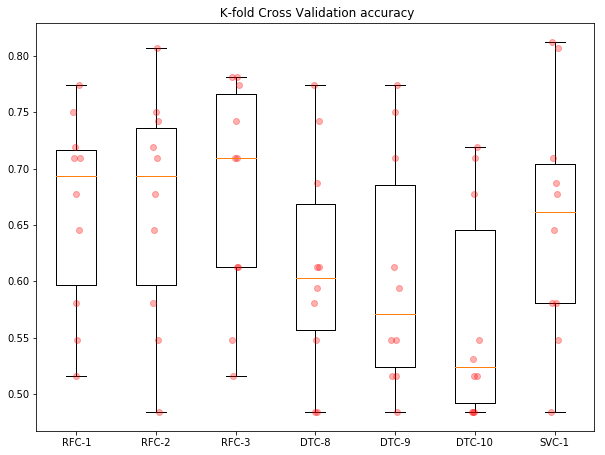

In [124]:
# Plot models performance
plt.figure(figsize=(10, 7.5))
plt.boxplot(acc)
plt.title(' K-fold Cross Validation accuracy')
for i in range(len(models)):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(models.keys())
pass

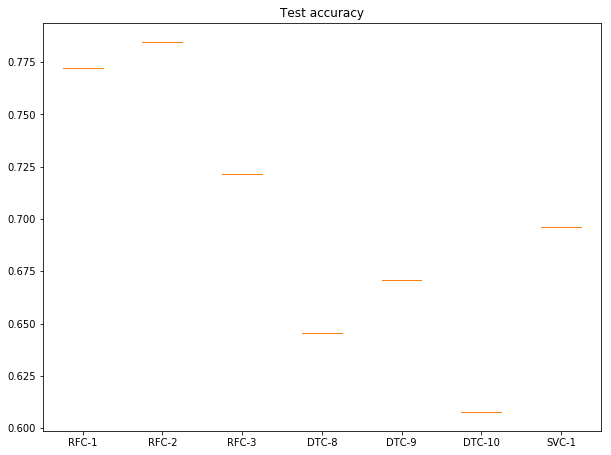

In [134]:
# Plot models performance
test_acc = np.zeros((1,len(models)))
for i, model in enumerate(models.values()):
    model.fit(X_t, y_t)
    predict = model.predict(X_test)
    test_acc[0][i] = metrics.accuracy_score(predict, y_test)

plt.figure(figsize=(10, 7.5))
plt.boxplot(test_acc)
plt.title('Test accuracy')
    
ax = plt.gca()
ax.set_xticklabels(models.keys())
pass

classification accuracy: 0.6329113924050633


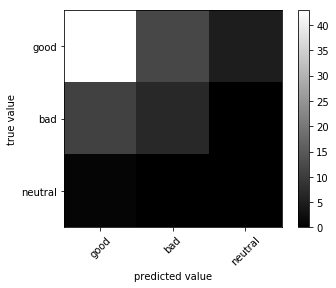

In [126]:
# Confusion matrix on test data
from sklearn import metrics

model = models['DTC-10']
model.fit(X_t, y_t)
y_pred = model.predict(X_test)

def plot_confusion_matrix(y, y_pred):
    plt.imshow(metrics.confusion_matrix(y, y_pred, labels=['good', 'bad', 'neutral']),
               interpolation='nearest',
               cmap=plt.cm.gray)
    plt.colorbar()
    tick_marks = np.arange(3)
    classes = ['good', 'bad', 'neutral']
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('true value')
    plt.xlabel('predicted value')

print ("classification accuracy:", metrics.accuracy_score(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [127]:
# Results on test data
model = models['DTC-10'] # Choose best model
model.fit(X, y)

predict = model.predict(test_clean)

df = pd.concat([test_id, pd.Series(predict)], axis=1)
df = df.rename({0: 'Prediction'}, axis='columns')
df.to_csv('final.csv', index=False, header=True)

bad        125
good        88
neutral     49
Name: Prediction, dtype: int64

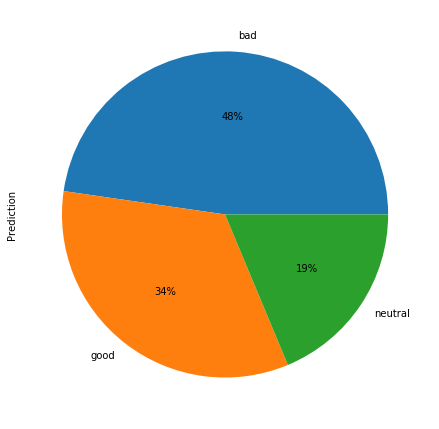

In [128]:
df.Prediction.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(7.5, 7.5))
df.Prediction.value_counts()

In [129]:
test_clean.head()

,Accelerated Healing,Adaptation,Agility,Animal Attributes,Animal Control,Animal Oriented Powers,Animation,Anti-Gravity,Astral Projection,Astral Travel,...,Vision - X-Ray,Vitakinesis,Wallcrawling,Water Control,Weapon-based Powers,Weapons Master,Weather Control,Web Creation,Weight,Wind Control
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.196017,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.163522,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.169811,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.443396,0
